In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


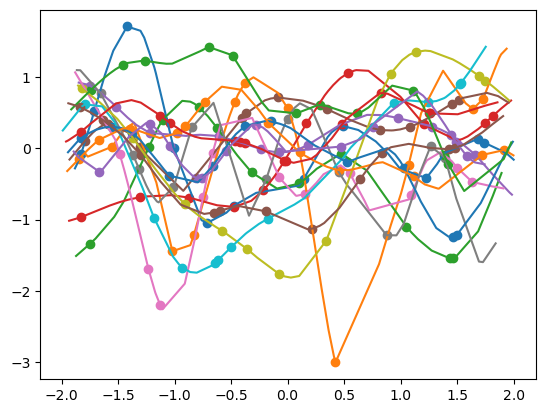

(47, 1) (11, 1)


In [12]:
from data.datasets import GPData

# Create dataset
dataset = GPData(sigma_range = (0.1, 1), ls_range=(0.1,0.6), max_num_context=97)

# Visualize data samples
batch = dataset.generate_batch()
(x_c, y_c), (x, y) = batch
for x_i, y_i in zip(x, y):
    plt.plot(x_i, y_i)

for xc_i, yc_i in zip(x_c, y_c):
    plt.scatter(xc_i, yc_i)
plt.show()
print(x_i.shape, xc_i.shape)

In [53]:
from src.np import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

model = NeuralProcess(
    x_dim=x_dim,
    y_dim=y_dim,
    hidden_dim=h_dim,
    latent_dim=z_dim,
    determ_dim=r_dim,
    n_h_layers_decoder=3,
    n_h_layers_phi_latent_encoder=2,
    n_h_layers_rho_latent_encoder=1,
    n_h_layers_phi_determ_encoder=6,
    n_h_layers_rho_determ_encoder=0,
    use_deterministic_path=False,
    use_bias=True,
    user_context_in_target=True
).to(device)
#model = NeuralProcess(
#                x_size = x_dim,
#                y_size = y_dim,
#                r_size = r_dim,
#                z_size = z_dim,
#                h_size_dec = h_dim,
#                h_size_enc_lat = h_dim,
#                h_size_enc_det = h_dim,
#                N_h_layers_dec = 3,
#                N_xy_to_si_layers = 2,
#                N_sc_to_qz_layers = 1,
#                N_h_layers_enc_det = 6,
#                use_r = False
#                ).to(device)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

23252


In [51]:
print(model)

NeuralProcess(
  (latent_encoder): LatentEncoder(
    (phi): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): Identity()
      )
    )
    (rho): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=100, bias=True)
        (3): Identity()
      )
    )
  )
  (decoder): Decoder(
    (target_transform): Linear(in_features=1, out_features=50, bias=True)
    (decoder): BatchMLP(
      (mlp): Sequential(
        (0): Linear(in_features=100, out_features=50, bias=True)
        (1): ReLU()
        (2): Linear(in_features=50, out_features=50, bias=True)
        (3): ReLU()
        (4): Linear(in_features=50, out_features=50, bias=True)
        (5): ReLU()

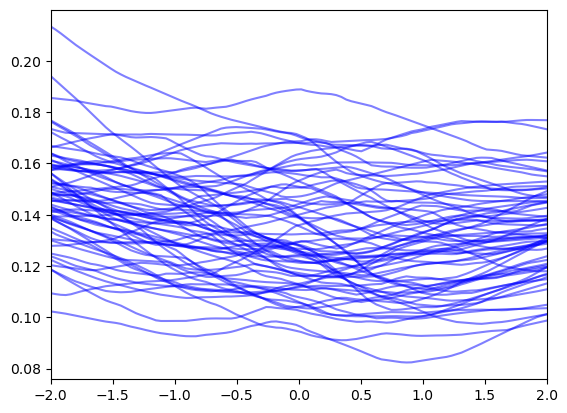

In [54]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-2, 2, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, 1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    py = model.decoder(x_target.to(device), z_sample.to(device))
    mu = py.mean
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().detach().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-2, 2)

In [55]:
from torch.utils.data import DataLoader
from torch.distributions.kl import kl_divergence
from src.utils import context_target_split
from random import randint

def _loss(p_y_pred, y_target, q_target, q_context):
        """
        Computes Neural Process loss.

        Parameters
        ----------
        p_y_pred : one of torch.distributions.Distribution
            Distribution over y output by Neural Process.

        y_target : torch.Tensor
            Shape (batch_size, num_target, y_dim)

        q_target : one of torch.distributions.Distribution
            Latent distribution for target points.

        q_context : one of torch.distributions.Distribution
            Latent distribution for context points.
        """
        # Log likelihood has shape (batch_size, num_target, y_dim). Take mean
        # over batch and sum over number of targets and dimensions of y
        log_likelihood = p_y_pred.log_prob(y_target).mean(dim=0).sum()
        # KL has shape (batch_size, r_dim). Take mean over batch and sum over
        # r_dim (since r_dim is dimension of normal distribution)
        kl = kl_divergence(q_target, q_context).mean(dim=0).sum()
        return -log_likelihood + kl


optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
model.training = True
avg_loss = 0

for iter in range(100000+1):
    (x_context, y_context), (x_target, y_target) = dataset.generate_batch(as_tensor=True, device=device)

    optimizer.zero_grad()
    p_y_pred, loss = model(x_context, y_context, x_target, y_target)

    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
    if iter % 10000 == 0 and iter > 0:
        print(f"iter {iter+1}: Avg. Loss = {avg_loss/1000}")
        avg_loss = 0



iter 10001: Avg. Loss = 573.2241077442169
iter 20001: Avg. Loss = 462.53144901919364
iter 30001: Avg. Loss = 372.6802984758019
iter 40001: Avg. Loss = 291.2733122507334
iter 50001: Avg. Loss = 275.61530364750325
iter 60001: Avg. Loss = 263.2806256377548
iter 70001: Avg. Loss = 250.6971281981766
iter 80001: Avg. Loss = 195.57286261558534
iter 90001: Avg. Loss = 151.4042121879831


In [56]:
print(f"iter {iter+1}: Avg. Loss = {avg_loss/1000}")
avg_loss = 0

iter 100000: Avg. Loss = 140.3405530122742


[autoreload of data.datasets failed: Traceback (most recent call last):
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/home/will/miniconda3/envs/pt2/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 323, in update_instances
    object.__setattr__(ref, "__class__", new)
TypeError: __class__ assignment: 'GPData' object layout differs from 'GPData'
]


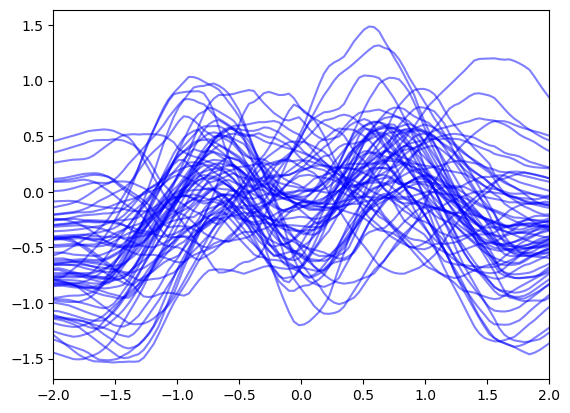

In [57]:
x_target = torch.Tensor(np.linspace(-2, 2, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, 1, z_dim))
    #xz = torch.cat((x_context, z_context), dim=2).to(device).float()
    py = model.decoder(x_target.to(device), z_sample.to(device))

    mu = py.mean
    plt.plot(x_target.cpu().numpy()[0], mu.detach().cpu().numpy()[0], 
             c='b', alpha=0.5)
    plt.xlim(-2, 2)

In [58]:
from src.utils import context_target_split

# Use batch to create random set of context points
(x_context, y_context), _ = dataset.generate_batch(batch_size device=device)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-2, 2, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0).to(device)

print(x_context[0].unsqueeze(0).shape, y_context.shape, x_target.shape)
model.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = model(x_context[0].unsqueeze(0), y_context[0].unsqueeze(0), x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.cpu().numpy()[0], mu.cpu().numpy()[0], 
                alpha=0.05, c='b')

plt.scatter(x_context[0].cpu().numpy(), y_context[0].cpu().numpy(), c='k')
plt.show()

TypeError: GPData.generate_batch() got an unexpected keyword argument 'as_tensor'